# Python Machine Learning 5 - Unsupervised Learning (PCA)
<p><a name="sections"></a></p>


## Sections

- <a href="#motivation">Motivation</a><br>
- <a href="#1st">The First Principal Component Direction</a><br>
- <a href="#1stcomp">The First Principal Component</a><br>
- <a href="#2nd">The Second Principal Component</a><br>
- <a href="#math">The Mathematical Formulation</a><br>
- <a href="#property">The Properties of Principal Components</a><br>
- <a href="#pca-sklearn">PCA in Scikit Learn</a><br>
 - <a href="#components">Components</a><br>
 - <a href="#transformation">Transformation</a><br>
 - <a href="#inverse">Inverse Transformation</a><br>
- <a href="#case1">Case 1: Iris Data</a><br>
- <a href="#case2">Case 2: Spam Filter</a><br>
- <a href="#case3">Case 3: Scaling</a><br>
- <a href="#case4">Case 4: Image Compression</a><br>

In [1]:
### Loading Packages
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
### Defining Necessary Functions
def rotate(array):
    data = [
        [1, 0, 0],
        [0, np.sqrt(3) / 2, -np.sqrt(1) / 2],
        [0, np.sqrt(1) / 2, np.sqrt(3) / 2]]
    rot = np.matrix(data=data).T
    return np.array(np.matrix(array) * rot)


def plot_vec(array, length, color='blue', alpha=1):
    kwargs = dict(
        color=color,  # color of the curve
        linewidth=1.4,  # thickness of the line
        # linestyle='--',  # available styles - -- -. :
        alpha=alpha,
    )
    ax.plot(*zip(-array[0] * length, array[0] * length), **kwargs)


def plot_plane(normal, color='blue', alpha=0.2, x_min=-1.5, x_max=2.5, y_min=-2.5, y_max=1.5):
    x_min_rng = list(range(int(np.floor(x_min) + 1), 0))
    x_max_rng = list(range(int(np.floor(x_max))))
    y_min_rng = list(range(int(np.floor(y_min) + 1), 0))
    y_max_rng = list(range(int(np.floor(y_max))))
    surf_x, surf_y = np.meshgrid(
        [x_min] + x_min_rng + x_max_rng + [x_max],
        [y_min]+ y_min_rng + y_max_rng + [y_max])
    surf_z = (-normal[0, 0]*surf_x - normal[0, 1]*surf_y - 0.5)* 1. / normal[0, 2]
    ax.plot_surface(surf_x, surf_y, surf_z, color=color, alpha=0.1)
    
    
def project2vec(data, vec, id_=0, color='green', along=False):
    pp = data[[id_]]
    proj = (np.sum(vec*pp)*vec)
    ax.scatter( *( proj.ravel() ), color=color, s=16)
    kwargs = dict(
        color=color,  # colour of the curve
        linewidth=1.4,  # thickness of the line
        # linestyle='--',  # available styles - -- -. :
        alpha=0.5,
    )
    ax.plot(*(zip(pp[0], proj[0])), **kwargs)
    if along:
        along_kwargs = dict(
            color='Dark' + color,  # colour of the curve
            linewidth=1.4,  # thickness of the line
            # linestyle='--',  # available styles - -- -. :
            alpha=1,
        )
        ax.plot(*(zip(np.array([0,0,0]), proj[0])), **along_kwargs)
    return np.sum(vec*pp)

def project2plane(data, normal, id_=0, color='green', shoot=False):
    pp = data[[id_]]
    proj = pp - np.sum((pp * normal)) * normal
    ax.scatter(*proj.ravel(), color=color, s=16)
    if shoot:
        kwargs = dict(
            color=color,  # colour of the curve
            linewidth=1.4,  # thickness of the line
            # linestyle = '--',  # available styles - -- -. :
            alpha=0.5,
        )
        ax.plot(*(zip(pp[0], proj[0])), **kwargs)
    return pp - np.sum(normal * pp) * normal    
    
def plot_origin():
    ax.scatter(0, 0, 0, marker='o', s=26, color='black', alpha=1)
    
def plotModel(model, x, y, label):
    '''
    model: a fitted model
    x, y: two variables, should arrays
    label: true label
    '''
    margin = 0.5
    x_min = x.min() - margin
    x_max = x.max() + margin
    y_min = y.min() - margin
    y_max = y.max() + margin
    import  matplotlib.pyplot as plt
    from matplotlib import colors
    col_dict = {
        'red': [(0, 1, 1), (1, 0.7, 0.7)],
        'green': [(0, 1, 0.5), (1, 0.7, 0.7)],
        'blue': [(0, 1, 0.5), (1, 1, 1)]
    }
    cmap = colors.LinearSegmentedColormap('red_blue_classes', col_dict)
    plt.cm.register_cmap(cmap=cmap)
    nx, ny = 200, 200
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, nx),
        np.linspace(y_min, y_max, ny)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ## plot colormap
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes')
    ## plot boundaries
    plt.contour(xx, yy, Z, [0.5], linewidths=1., colors='k')
    plt.contour(xx, yy, Z, [1], linewidths=1., colors='k')
    ## plot scatters ans true labels
    plt.scatter(x, y, c=label, edgecolors='k')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    ## if it's a SVM model
    if hasattr(model, 'support_'):
        # if it's a SVC, plot the support vectors
        index = model.support_
        plt.scatter(x[index], y[index], c=label[index], s=150, alpha=0.5, edgecolors='k')

<p><a name="motivation"></a></p>
## Motivation

In some cases, it is obvious that we don't need all the components. For example

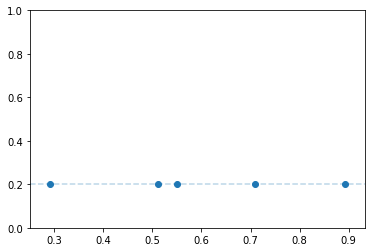

In [3]:
np.random.seed(3)
x = np.random.rand(5)
y = np.array([0.2]*5)
plt.scatter(x, y)
plt.ylim(-0, 1)
plt.axhline(y=0.2, linestyle='--', alpha=0.3)
plt.show()

Each observation has two components in its coordinate. Do we really need two?

- We don't. The `y` component of all the points are the same, it provides **NO** information.

Consider this example. None of the components are constant, but if we need to pick only one component among the two axses, how do we decide?

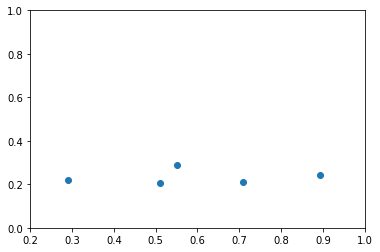

In [4]:
np.random.seed(3)
x = np.random.rand(5)
y = np.random.rand(5) * 0.1 + 0.2
plt.scatter(x, y)
plt.ylim(-0, 1)
plt.xlim(0.2, 1)
plt.show()

One way to compare is to project the observations to the two axes.

- For `x` axis, the projection spreads in a range around 0.3 to 0.9.

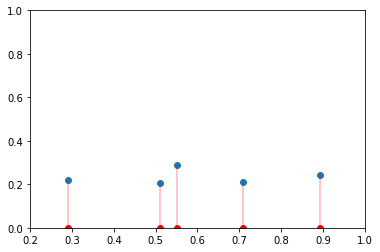

In [5]:
for i in range(len(x)):
    plt.plot([x[i], x[i]], [y[i], 0], color='red', alpha=0.3)
    
plt.scatter(x, y)
plt.scatter(x, np.zeros(len(x)), color='red')
plt.ylim(-0, 1)
plt.xlim(0.2, 1)
plt.show()

- In contrast, `y` is restricted in a much smaller region. This suggests that `x` component might provide more information, because all the `y` components are "about the same".

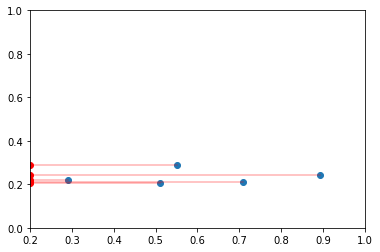

In [6]:
for i in range(len(x)):
    plt.plot([x[i], 0], [y[i], y[i]], color='red', alpha=0.3)
    
plt.scatter(x, y)
plt.scatter(np.ones(len(x)) * 0.2, y, color='red')
plt.ylim(-0, 1)
plt.xlim(0.2, 1)
plt.show()

This motivates the idea of PCA. We are searching for, among all the possible direction, the direction along which the projection of the observations are most widely spreaded.

We emphasize that the motivation above can be a little misleading. Even in the two dimensional space, we can have **infinitely** many directions, not just along hte two axes.

Below we illustrate how PCA works in a three dimensional space. The process can be easily generalized into any high dimensional space.

In [7]:
#### Simulating Data

n = 20
np.random.seed(108)
z = 10. * np.random.rand(n) - 5
theta = 2 * np.pi * np.random.rand(n)
a = 5 - np.abs(z)
x = a / 2.5 * np.cos(theta)
y = a / 5. * np.sin(theta)
data = np.zeros((n, 3))
data[:, 0] = x
data[:, 1] = y
data[:, 2] = z
data = rotate(data)

pca = PCA()
first = pca.fit(data).components_[[0]]
second= pca.fit(data).components_[[1]]
third = pca.fit(data).components_[[2]]
raw_data = data
data = data - pca.mean_

<p><a name="1st"></a></p>
## The First Principal Component Direction

Consider a set of 20 observations in a three dimensional space. This often represents a case when we have:

- 20 observations.
- 3 features.

We visualize the data below. The black point is the origin.

In [8]:
print(data.shape)

(20, 3)


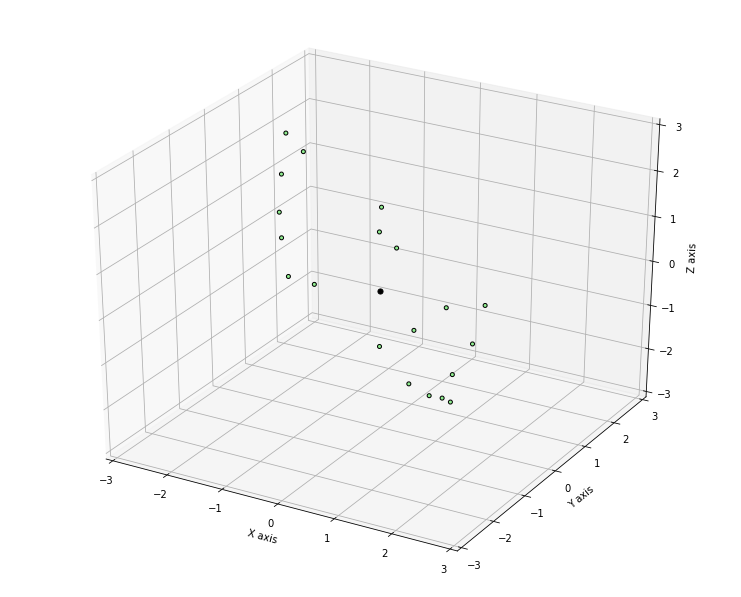

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=1)
plot_origin()

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

Below we visualize how we compare the **importance** of each direction. Note that the directions in the example are not the coordinate direction.

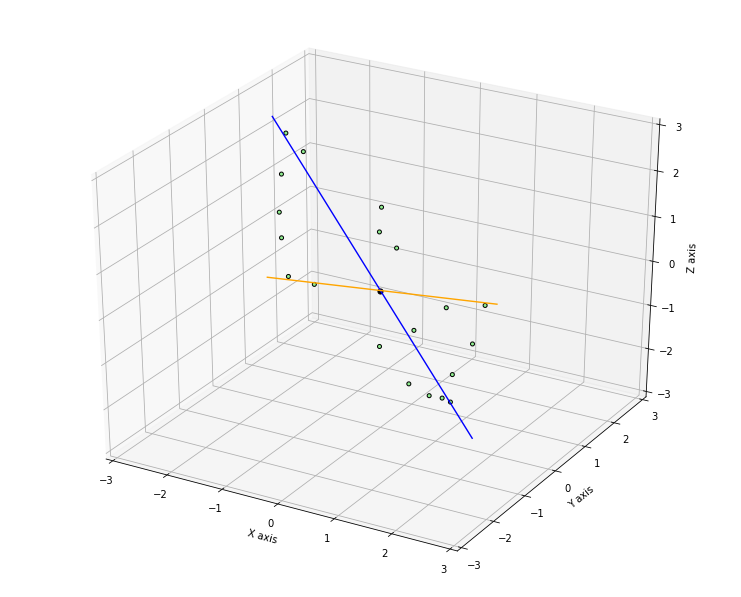

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=1)
plot_origin()
plot_vec(first, 6)

arbi = np.array([[ 0.99249426,  0.05066054,  0.1113043 ]])
plot_vec(arbi, 2, color='orange')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show() 

We project each observation to the "orange" direction:

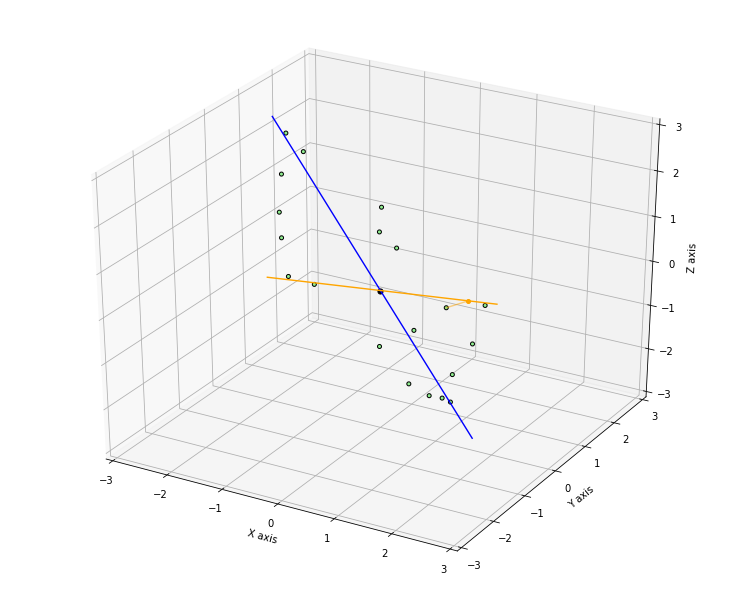

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=1)
plot_origin()
plot_vec(first, 6)


plot_vec(arbi, 2, color='orange')


len_proj = project2vec(data, arbi, id_=13, color='orange', along=False)


ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

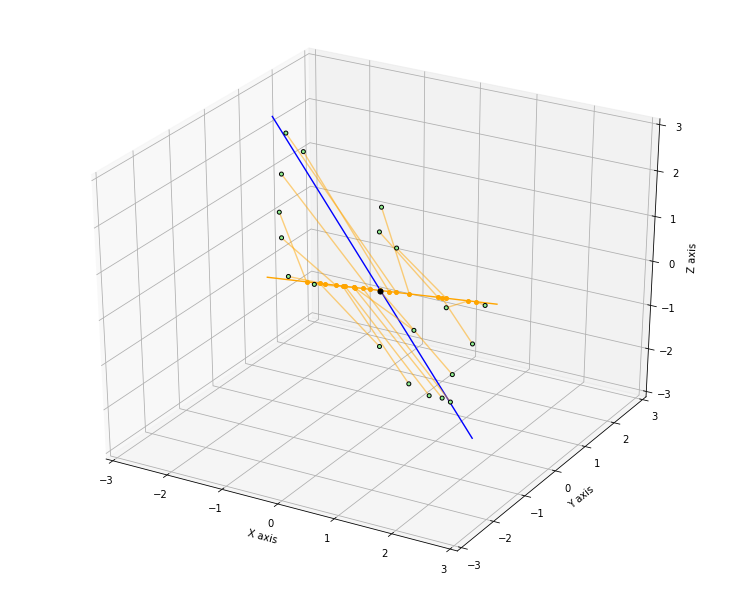

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=1)
plot_origin()
plot_vec(first, 6)


plot_vec(arbi, 2, color='orange')

proj_arbi = []
for i in range(n):
    len_proj = project2vec(data, arbi, id_=i, color='orange', along=False)
    proj_arbi.append(len_proj)


ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

Project to the "blue" direction in the same way:

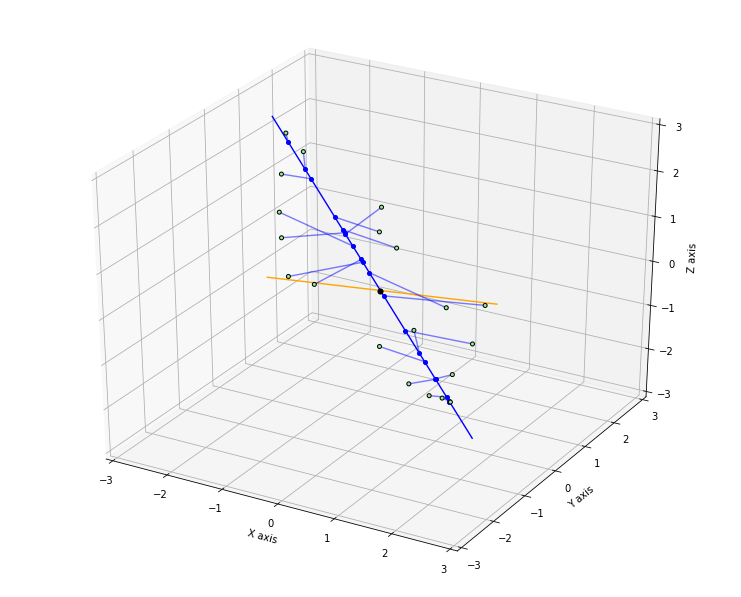

In [13]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=1)
plot_origin()
plot_vec(first, 6)


plot_vec(arbi, 2, color='orange')

proj_first = []
for i in range(n):
    len_first = project2vec(data, first, id_=i, color='blue', along=False)
    proj_first.append(len_first)


ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

The projection of the observations on the "blue" direction spread more widely than the one on the "orange" direction.

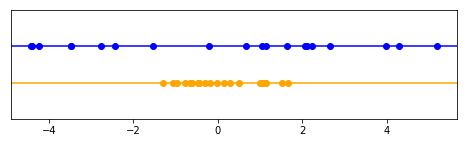

In [14]:
fig = plt.figure(figsize=(8, 2))
plt.scatter(proj_first, np.ones(n) * 2, color='blue')
plt.axhline(y=2, color='blue')
plt.scatter(proj_arbi, np.ones(n), color='orange')
plt.axhline(y=1, color='orange')
plt.ylim(0, 3)
plt.yticks([])
plt.show()

The "blue" direction above is actually the **first principal component**, which means:

- it is the direction on which the projection of the observations is more widely spread than the projetion on any other direction.

- being a direction (vector), it has as many components as the number of the features usually.

Note that we characterized the first principal component direction, but we didn't show how it's found. We will discuss that but if you don't care about math, Python will find it for you.

The statements above charaterizes the proncipal component direction. To find the principal component direction, we need to apply **linear algebra** which we will discuss later. However, if you don't care about math, Python will find it for you.

<p><a name="1stcomp"></a></p>
## The First Principal Component

With the first principal component direction (heuristically the most important one), we want to keep, from all the observations, only the information recorded in this direction.

This is again done by projection.

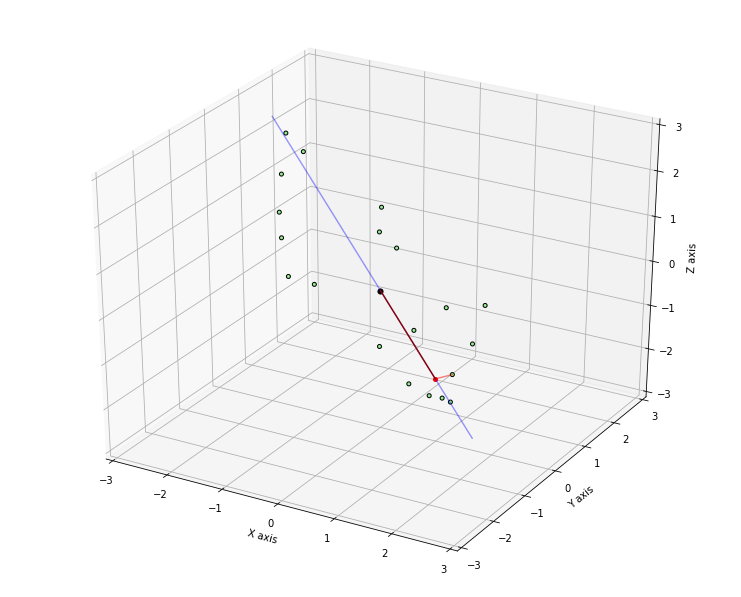

In [15]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=1)
plot_origin()
plot_vec(first, 6, alpha=0.4)

proj_len = project2vec(data, first, id_=3, color='red', along=True)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

In this particular example, projecting 30 observations to the principal component direction gives us a vector of length 30. This vector is the **first principal component**.

**Remark**
- We have 30 observations originally, so we still need 30 records for all the observations.
- We no longer use the `x`-`y`-`z` coordinates to record the information for each observation, with the first principal component we use **one** coordinate only -- but this coordinate is supposed to provide the most information.

We also remark here a little side effect that the projection (red part) can be described in two ways:

- a certain length away from the origin along the PCA direction.
- a vector in the original `x`-`y`-`z` coordinate.

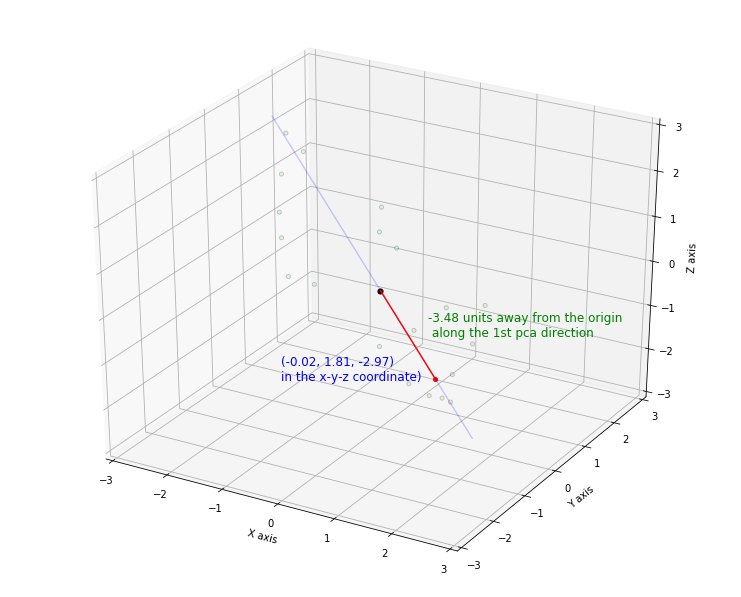

In [16]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=0.2)
plot_origin()
plot_vec(first, 6, alpha=0.2)
ax.scatter(*(proj_len*first[0]), marker='o', s=16, color='red', alpha=1)
ax.plot(*(zip(np.array([0,0,0]), proj_len*first[0])), 
        color='red', linewidth=1.4, alpha=1)

pca_fmt = '%.2f units away from the origin\n along the 1st pca direction'
pca_coord_txt = pca_fmt % proj_len 
ax.text(-0.01044 + 0.2, 1.164, -1.585, pca_coord_txt, color='green', size=12)

origin_fmt = '(%.2f, %.2f, %.2f)\nin the x-y-z coordinate)'
origin_coord_txt = origin_fmt %tuple((proj_len*first[0]))
ax.text(-0.01044 - 1.8, 0.964 - 1, -1.585 - 1, origin_coord_txt, color='blue', size=12)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

<p><a name="coord_change"></a></p>
We will see later the plot above demonstrates the coordinate change.

<p><a name="2nd"></a></p>
## The Second Principal Component

The first principal component provides the most information, but most likely **NOT** all. To find the next most important direction, we need to:

- First, remove the information recorded in the first principal component
- Then we again find the direction on which the projection of the observations spread most widely.

Consider the plane that is perpendicular to the first principal component direction:

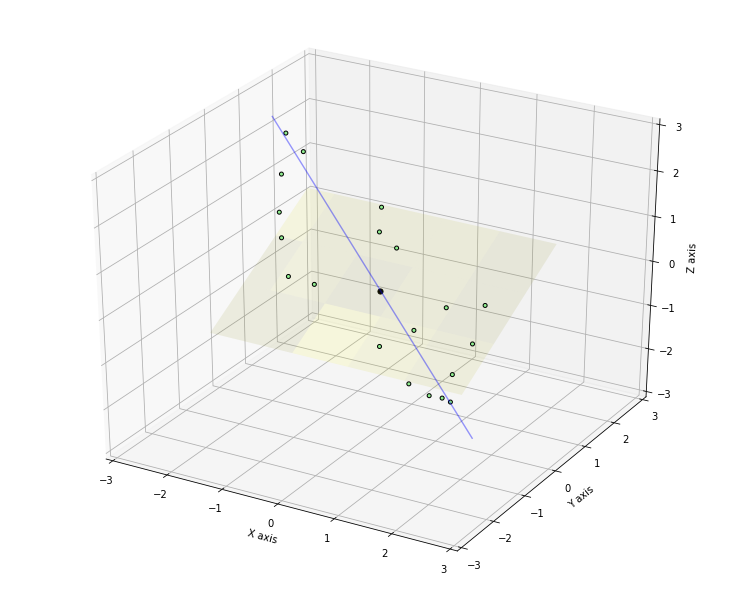

In [17]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=1)
plot_origin()
plot_vec(first, 6, alpha=0.4)
plot_plane(first, color='yellow', alpha=0.2, x_min=-2.5, x_max=2, y_min=-1, y_max=2)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

We can remove the effect of the first principal component by projecting the observations to this plane:

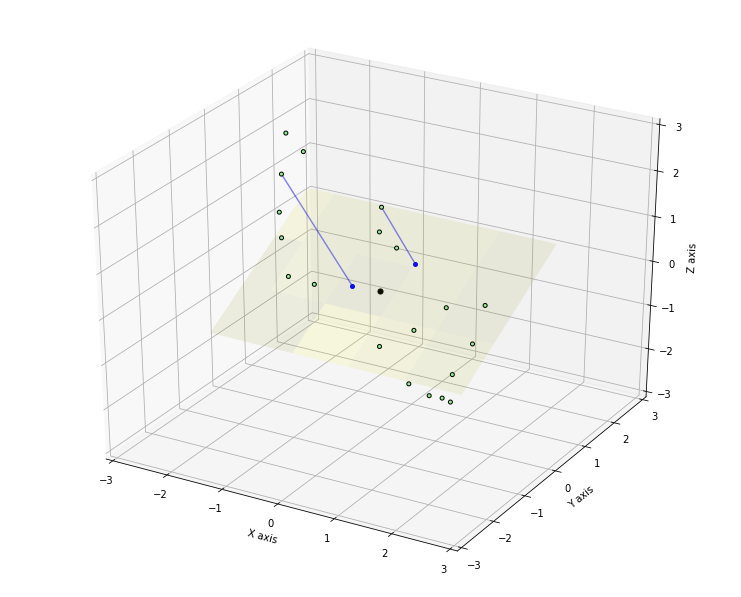

In [18]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=1)
plot_origin()
plot_plane(first, color='yellow', alpha=0.2, x_min=-2.5, x_max=2, y_min=-1, y_max=2)

proj_on_plane=[]
for i in [5, 6]:
    aa= project2plane(data, first, id_=i, color='blue', shoot=True )
    proj_on_plane.append(aa)

    
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

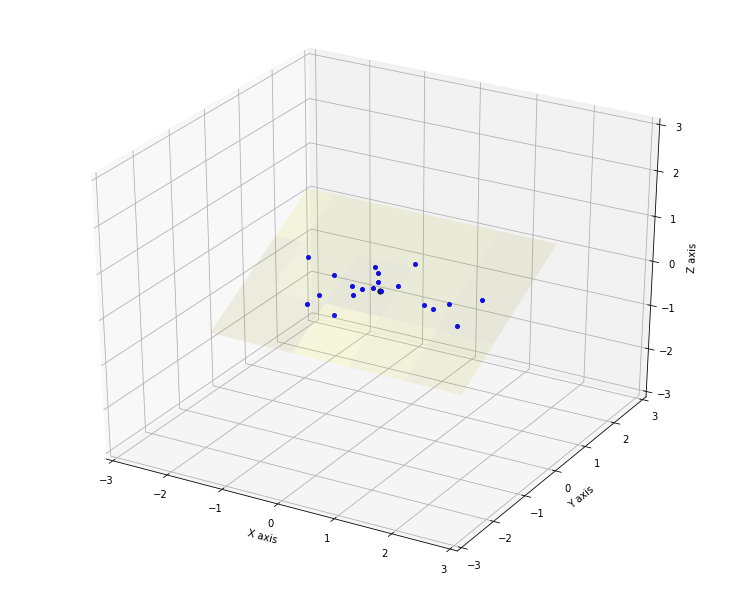

In [19]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

plot_origin()
plot_plane(first, color='yellow', alpha=0.2, x_min=-2.5, x_max=2, y_min=-1, y_max=2)

for i in range(n):
    project2plane(data, first, id_=i, color='blue')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

By applying the same trick in linear algebra (which we didn't discuss), we can find the direction on which the projections spread most widely. 

- Since all the observations are now in the plane, the direction we find would be automatically **in** the plane and is perpendicular to the first principal component direction.

This is the **second principal component direction**. The projection of the observations to this direction is the **second principal component**.

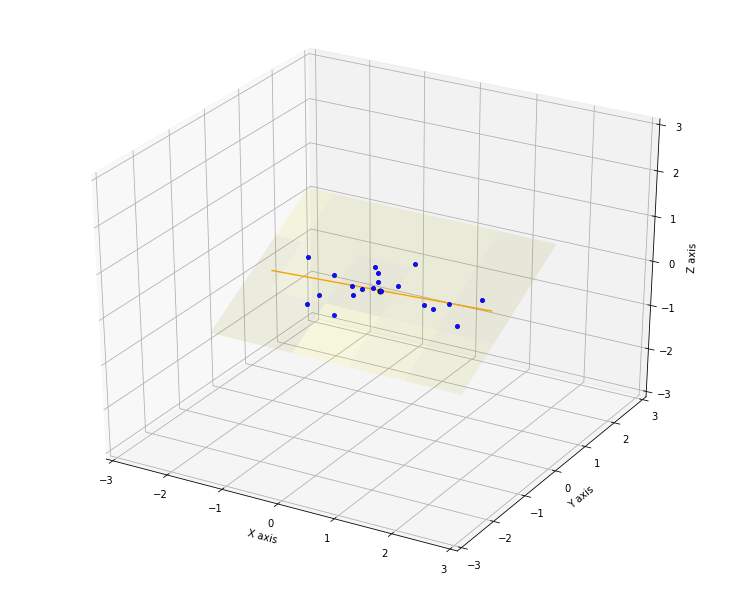

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

plot_origin()
plot_plane(first, color='yellow', alpha=0.2, x_min=-2.5, x_max=2, y_min=-1, y_max=2)
plot_vec(second, 1.9, alpha=1, color='orange')

for i in range(n):
    project2plane(data, first, id_=i, color='blue')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

**Remark** Clearly this process can be continue to retain more and more information. However, as we can see from the process above, each time we remove the information recorded in a principal component direction, we remove **one** dimension. So we can't have more principal component than the amount of original features we have.

Below we visualize, for the example above, the observations and all its principal component directions:

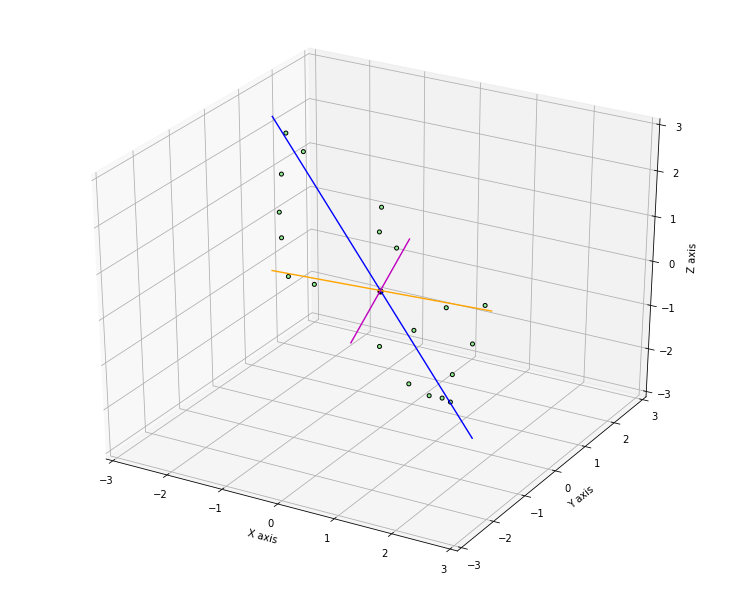

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(*data.T, marker='o', s=16, c='Lightgreen', edgecolors='k', alpha=1)
plot_origin()
plot_vec(first, 6, color='blue', alpha=1)
plot_vec(second, 1.9, color='orange', alpha=1)
plot_vec(third, 1.2, color='m', alpha=1)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

<p><a name="math"></a></p>
## The Mathematical Formulation

In this section we identify all the elements we saw in the visualization with the mathematical formula. It is a good transition between the visualization and the Python code. To be compatible with the notation in Python, vectors are row vectors below.

- The first (very important) step we need to do is to centralize the data. We may then assume our data $X$ is an `n` by `p` matrix (that means we have a data set of `n` observations and `p` features). The average of each column is 0.
- We then project the data into any possible direction. A direction is represented by a unit vector $\hat{u}$ in linear algebra, and the projection is $ X \hat{u}^{\text{T}} $

**Question** What is the dimension of $\hat{u}$ ? What is the dimensions of $X \hat{u}^{\text{T}}$ ? Why do these dimension make sense?

- As we discussed, we need to find the direction on which the projection of the data **spread most widely**. In the mathematical formulation, it can be stated as:

$$
\text{maximize Var} ( X \hat{u}^{\text{T}} )\\
\text{subject to } \| \hat{u} \| = 1
$$

The solution to the optimization problem above is the **first principal component direction**, denoted by $ \phi_1 $. The projection of our data $X$ on the first principal component direction is $ Z_1 = X \phi_1^{\text{T}}$, which is called the **first principal component**.

Once the first k-1 principal components are found, the next one (if there is one) can be found inductively.

- We first remove the information about the first k-1 components from $X$ ($X_k$ denotes the resulted matrix). 
$$
X_k =  X - \sum_{i=1}^{k-1} X \phi_i \phi_i^{\text{T}}
$$

- With this matrix we solve the optimization problem again:
$$
\text{maximize Var} ( X_k \hat{u}^{\text{T}} )\\
\text{subject to } \| \hat{u} \| = 1
$$

Again the solution $\phi_k$ is the **kth principal component direction** and the projection on this direction, $Z_k = X_k \hat{u}^{\text{T}}$, is called the **kth principal component**.

- **Note** Solving an optimization problem can be hard. In the setting of PCA, this is relatively easy. The principal component directions are (essentially) the **eigenvectors** of the covariance matrix of the data, arranged in the descending order of the eigenvalues they correspond to.

<p><a name="property"></a></p>
## The Properties of Principal Components

1. There are most `min(n, p)` principal components (but we often assume `p` of them).
2. The variances of each principal components decreases:
$$
\text{Var}(Z_1) ≥ \text{Var}(Z_2) ≥ ... ≥ \text{Var}(Z_p)
$$
3. The principal components $Z_1, Z_2, ..., Z_p$ are mutually uncorrelated.
4. The principal component directions
$
\phi_1, \phi_2, ..., \phi_p
$
are normalized and mutually perpendicular.

<p><a name="pca-sklearn"></a></p>
## PCA in Scikit Learn
In order to implement PCA in Python, import the class `PCA` from *sklearn.decomposition*.

In [38]:
from sklearn.decomposition import PCA
pca = PCA()

**Arguments**: 

- **n_components**: Number of components to keep. In default it is `min(`n_samples, n_features`)`.

**Attributes**:

- **components_**: Components with maximum variance.
- **explained\_variance\_ratio\_**: Percentage of variance explained by each of the selected components. 
- **mean_**: The average of each feature.

**Methods:**

- **fit**: Fit the model with X.
- **fit_transform**: Fit the model with X and apply the dimensionality reduction on X.
- **inverse_transform**: Transform data back to its original space.
- **get_covariance**: Compute data covariance with the generative model.
- **get_params**: Get parameters for this estimator.
- **set_params**: Set the parameters of this estimator.
- **transform**: Apply the dimensionality reduction on X.

Here is a simple example. Let's use the data we visualize. For visualization, we have manually centralized the data. Here we use the data without being centralized, we will see that Python take care of this for us.

In [39]:
#### Simulating Data

n = 20
np.random.seed(108)
z = 10. * np.random.rand(n) - 5
theta = 2 * np.pi * np.random.rand(n)
a = 5 - np.abs(z)
x = a / 2.5 * np.cos(theta)
y = a / 5. * np.sin(theta)
data = np.zeros((n, 3))
data[:, 0] = x
data[:, 1] = y
data[:, 2] = z
data = rotate(data)

Fit a PCA model on this data set.

In [24]:
pca.set_params(n_components=3)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<p><a name="components"></a></p>
### Components
- The Components.

In [25]:
pca.components_

array([[ 0.00561615, -0.51982923,  0.85425174],
       [ 0.99833705,  0.05192669,  0.02503501],
       [ 0.05737239, -0.85269056, -0.51925641]])

- Percentage of variance explained by each of the selected components.

In [26]:
pca.explained_variance_ratio_

array([0.91946343, 0.06889109, 0.01164548])

- The average of each original feature.

In [27]:
pca.mean_ 

array([ 0.11607567,  0.06958714, -0.23419675])

<p><a name="transformation"></a></p>
### Transformation
- Apply PCA to the data set.

In [28]:
data_pca = pca.transform(data)
data_pca

array([[-2.4392621 , -0.29637691, -0.47254513],
       [-4.41950029,  0.02124758,  0.00700332],
       [ 1.0478845 , -1.03028144,  0.57822653],
       [-3.47502069,  0.2388807 , -0.16370817],
       [ 2.10448454, -0.9249651 ,  0.33517571],
       [ 2.06027818,  0.31813068, -0.68659427],
       [ 3.96882531, -0.48573685,  0.00916314],
       [-3.49047456, -0.39461696,  0.21142968],
       [ 1.14862206, -0.50304539,  0.69195295],
       [-4.23839472, -0.30242202,  0.04104226],
       [-1.53454089,  1.1812612 ,  0.01521322],
       [-0.20243544,  1.66058848, -0.19115841],
       [ 4.27952877, -0.18524014, -0.35408148],
       [ 0.6676361 ,  1.48915977,  0.4338948 ],
       [-4.39549901, -0.13943659, -0.03314867],
       [ 2.21915832,  0.98140717,  0.18064288],
       [ 5.17373413, -0.11700124, -0.1751927 ],
       [-2.77087489, -0.86971037, -0.14026802],
       [ 1.63751837, -1.44644778, -0.42903243],
       [ 2.65833231,  0.8046052 ,  0.14198478]])

- To transform manually with the formula we provided before, we need to manually centralize the data and then project.

In [29]:
np.dot(data - pca.mean_,  pca.components_.T)

array([[-2.4392621 , -0.29637691, -0.47254513],
       [-4.41950029,  0.02124758,  0.00700332],
       [ 1.0478845 , -1.03028144,  0.57822653],
       [-3.47502069,  0.2388807 , -0.16370817],
       [ 2.10448454, -0.9249651 ,  0.33517571],
       [ 2.06027818,  0.31813068, -0.68659427],
       [ 3.96882531, -0.48573685,  0.00916314],
       [-3.49047456, -0.39461696,  0.21142968],
       [ 1.14862206, -0.50304539,  0.69195295],
       [-4.23839472, -0.30242202,  0.04104226],
       [-1.53454089,  1.1812612 ,  0.01521322],
       [-0.20243544,  1.66058848, -0.19115841],
       [ 4.27952877, -0.18524014, -0.35408148],
       [ 0.6676361 ,  1.48915977,  0.4338948 ],
       [-4.39549901, -0.13943659, -0.03314867],
       [ 2.21915832,  0.98140717,  0.18064288],
       [ 5.17373413, -0.11700124, -0.1751927 ],
       [-2.77087489, -0.86971037, -0.14026802],
       [ 1.63751837, -1.44644778, -0.42903243],
       [ 2.65833231,  0.8046052 ,  0.14198478]])

<p><a name="inverse"></a></p>
### Inverse Transformation

- Inverse tranformation is of course the "inverse" of the transformation to the principal component directions. Therefore:

In [30]:
pca.inverse_transform(data_pca) == data  ### What's wrong with this code?

array([[False,  True, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False,  True, False],
       [False,  True, False],
       [False, False, False],
       [False,  True, False],
       [False,  True, False],
       [False, False, False],
       [False,  True, False],
       [False, False, False],
       [False, False, False],
       [ True,  True, False],
       [False, False, False],
       [ True, False, False],
       [False, False, False],
       [False, False, False]])

**We don't get every element `True` because of numerical error.**

However, the real usage of `pca.inverse_transform` lies in coordinate change. We often have to change back to the `x`-`y`-`z` coordinate anyway. For example, if we decide to keep only the most important direction, then after the PCA transformation there will be only one feature.

In [31]:
pca.set_params(n_components=1)
pca.fit(data)
pca.transform(data)

array([[-2.4392621 ],
       [-4.41950029],
       [ 1.0478845 ],
       [-3.47502069],
       [ 2.10448454],
       [ 2.06027818],
       [ 3.96882531],
       [-3.49047456],
       [ 1.14862206],
       [-4.23839472],
       [-1.53454089],
       [-0.20243544],
       [ 4.27952877],
       [ 0.6676361 ],
       [-4.39549901],
       [ 2.21915832],
       [ 5.17373413],
       [-2.77087489],
       [ 1.63751837],
       [ 2.65833231]])

But if we want to plot a 3D scatter plot, we need to change back to `x`-`y`-`z` coordinate. Compare <a href="#coord_change">this plot</a><br> with the computation below. The projection of the fourth row in our data:
- is -3.47 units away from the origin along the first principal component. (after transform)
- has the difference around `(-0.02, 0.08, -3.47)` from the center.

In [32]:
pca.transform(data[[3]])

array([[-3.47502069]])

In [33]:
pca.inverse_transform( pca.transform(data[[3]]) ) - pca.mean_

array([[-0.01951623,  1.80641732, -2.96854247]])

<p><a name="case1"></a></p>
## Case 1: Iris Data
- In this case, we will try to fit PCA on the four features of the iris data, extract the first two components so we can visualize them.

In [42]:
from sklearn import datasets
iris = datasets.load_iris()

- Fit `pca` with the data:  

In [46]:
#### Your code here
data = iris.data

pca.set_params(n_components=2)
iris.data2 = pca.fit_transform(data)

- The percentage of variance explained by the first two components:

In [47]:
#### Your code here
print(pca.explained_variance_ratio_)

[0.92461621 0.05301557]


- We can see that the first two components contain almost 98% of the variance.
- Plot the principal components in a 2D coordinate system.

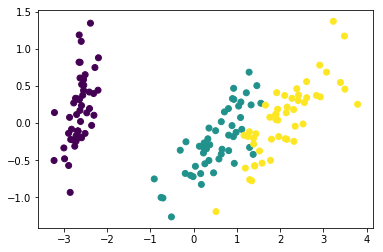

In [49]:
plt.scatter(iris.data2[:, 0], iris.data2[:, 1], c=iris.target)
plt.show()

- At the end, we can fit a classifier on the transformed features. In this case, we fit a logistic regression.
- Previously, we have seen that the **`LogisticRegression`** function fits an L2 penalized logistic regression, and the objective function to be minimized is:

$$\min \frac{1}{2} \beta^T\beta + C\sum_{i=1}^{n} \log(1 + e^{-y^{(i)}\beta^Tx^{(i)}})$$
- A large C decreases the effect of the regularization term($\beta^T\beta$). Here we set $C = 10^5$.

In [50]:
import sklearn.linear_model as lm
logit = lm.LogisticRegression(C=1e5) 
logit.fit(iris.data2, iris.target)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [51]:
logit.score(iris.data2, iris.target)

0.9666666666666667

By using these two components, the accuracy of logistic regression is 96.67%.

What about using two of the original features? Let's try all the possible combination of the features. 

In [52]:
features_num = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
accuracy = []
for i in features_num:
    logit.fit(iris.data[:, i], iris.target)
    accuracy.append(logit.score(iris.data[:, i], iris.target))
accuracy

[0.8066666666666666,
 0.96,
 0.9466666666666667,
 0.9533333333333334,
 0.9533333333333334,
 0.96]

features | accuracy
---------|------------
0, 1     | 80.67%
0, 2     | 96%
0, 3     | 94.67%
1, 2     | 95.33%
1, 3     | 95.33%
2, 3     | 96%
two principal components | **96.67%**

Comparing the accuracies, we can see that any two features are not as good as the components we get from PCA, which is not surprising.

<p><a name="case2"></a></p>
## Case 2: Spam Filter

- Let's try to fit a PCA model on the spam data. 
- Recall that we have 58 features in the spam data.

In [55]:
## prepare data
import pandas as pd
spam_train = pd.read_csv('./data/spam_train.csv')
spam_test = pd.read_csv('./data/spam_test.csv')
x_train = np.array(spam_train.iloc[:, :57])
y_train = np.array(spam_train.iloc[:, -1])
x_test = np.array(spam_test.iloc[:, :57])
y_test = np.array(spam_test.iloc[:, -1])

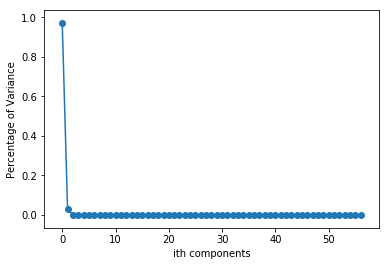

In [56]:
pca.set_params(n_components=None)
pca.fit(x_train)
plt.plot(range(57), pca.explained_variance_ratio_)
plt.scatter(range(57), pca.explained_variance_ratio_)
plt.xlabel('ith components')
plt.ylabel('Percentage of Variance')
plt.show()

Surprisingly, the first two components contain almost all of the information in the 58 features.

- Extract the first two principal components so that we can visualize them.

In [62]:
#### Your code here
pca.set_params(n_components=2)
pca.fit(x_train)
x_train2 = pca.transform(x_train)


- The percentage of variance explained by each of the selected components.

In [63]:
print(pca.explained_variance_ratio_)

[0.96989593 0.02956787]


- The total percentage of variance explained by the first two components.

In [64]:
print(np.sum(pca.explained_variance_ratio_))

0.9994637972530358


- Visualize the first two components:

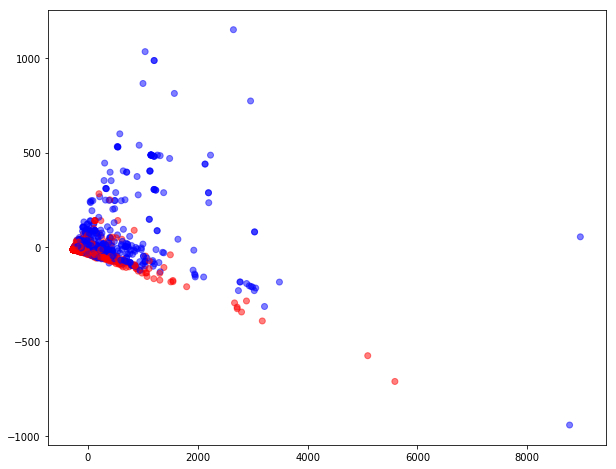

In [65]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
plt.scatter(x_train2[:, 0], x_train2[:, 1], c=['red' if i == 'email' else 'blue' for i in y_train ], alpha=0.5)
plt.show()

- We can now build a model using the principal components. In this case, we'll make a logistic regression.

In [66]:
import sklearn.linear_model as lm
logit = lm.LogisticRegression()
y_train2num = [1 if i == 'email' else 0 for i in y_train]
logit.fit(x_train2, y_train2num)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

C:\Users\mlu\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


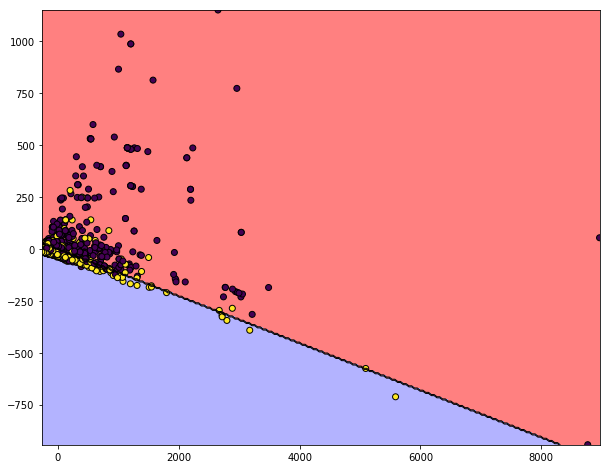

In [67]:
plotModel(logit, x_train2[:, 0], x_train2[:, 1], y_train2num)
plt.show()

When predicting, we should make the **same transformation** on the new observations.

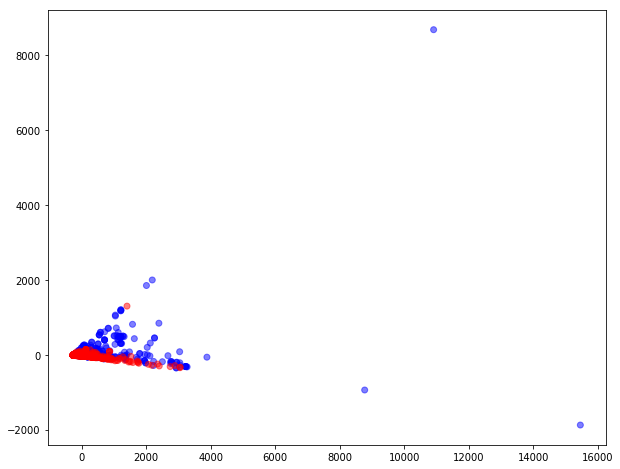

In [68]:
x_test2 = pca.transform(x_test) # transformation
plt.scatter(x_test2[:, 0], x_test2[:, 1], c=['red' if i == 'email' else 'blue' for i in y_test], alpha=0.5)
plt.show()

In [69]:
logit.fit(x_train2, y_train)
print("The training error is: %.4f" %(1 - logit.score(x_train2, y_train)))
print("The test     error is: %.4f" %(1 - logit.score(x_test2, y_test)))

The training error is: 0.2752
The test     error is: 0.2690


Both the training error and test error here are very high.

<p><a name="case3"></a></p>
## Case 3: Scaling

- Recall that the range of all the features in the spam data are not the same.

In [70]:
spam_train.head()

,A.1,A.2,A.3,A.4,A.5,A.6,A.7,A.8,A.9,A.10,...,A.49,A.50,A.51,A.52,A.53,A.54,A.55,A.56,A.57,spam
0,0.32,0.0,0.00,0.0,0.32,0.00,0.0,0.0,0.0,0.0,...,0.0,0.234,0.0,0.058,0.0,0.0,1.068,3,47,email
1,0.00,0.0,0.71,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.342,0.0,0.0,1.000,1,31,email
2,0.00,0.0,0.00,0.0,0.00,0.17,0.0,0.0,0.0,0.0,...,0.0,0.055,0.0,0.000,0.0,0.0,1.685,7,204,email
3,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000,0.0,0.0,1.800,5,9,email
4,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.471,0.0,0.000,0.0,0.0,1.424,8,47,email


$A.1$ to $A.52$ range from 0 to 1, while $A.55, A.56, A.57$ have values larger than 1.  It's better to scale them to have a standardized deviation.

Since the features are in different ranges, it's better to scale the features. 

Divide each feature with its standard deviation:
$$X_i^{scale} = \frac{X_i}{\sqrt{var(X_i)}}$$

- Scale x_train, call it x_train_scale

In [72]:
#### You code here
x_train_scale = x_train / np.std(x_train, 0)

- Fit PCA again.

In [73]:
pca.set_params(n_components=None)
pca.fit(x_train_scale)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

- The percentage of variance explained by each component.

In [74]:
pca.explained_variance_ratio_

array([1.21098354e-01, 6.16930434e-02, 3.36458801e-02, 2.85825238e-02,
       2.74415678e-02, 2.62562324e-02, 2.43453131e-02, 2.42479292e-02,
       2.31037983e-02, 2.27596853e-02, 2.19171742e-02, 2.07387924e-02,
       2.03940156e-02, 2.01233015e-02, 1.95903439e-02, 1.86435703e-02,
       1.81481587e-02, 1.80808578e-02, 1.80395678e-02, 1.74790946e-02,
       1.74243853e-02, 1.72865484e-02, 1.70347514e-02, 1.66831398e-02,
       1.65746339e-02, 1.61106254e-02, 1.57736504e-02, 1.52237259e-02,
       1.50203802e-02, 1.45321223e-02, 1.40571677e-02, 1.37936350e-02,
       1.35968400e-02, 1.34835216e-02, 1.29050379e-02, 1.28424624e-02,
       1.24631100e-02, 1.23004874e-02, 1.17377034e-02, 1.17009292e-02,
       1.12713268e-02, 1.10070891e-02, 1.01087887e-02, 9.97580104e-03,
       9.60285139e-03, 9.23276774e-03, 8.97941126e-03, 8.15791550e-03,
       7.97386499e-03, 7.01899003e-03, 6.50114674e-03, 5.91022153e-03,
       5.29012293e-03, 4.35844007e-03, 4.11261687e-03, 3.56475519e-03,
      

The first component only has 12.11% of the variance at this time.

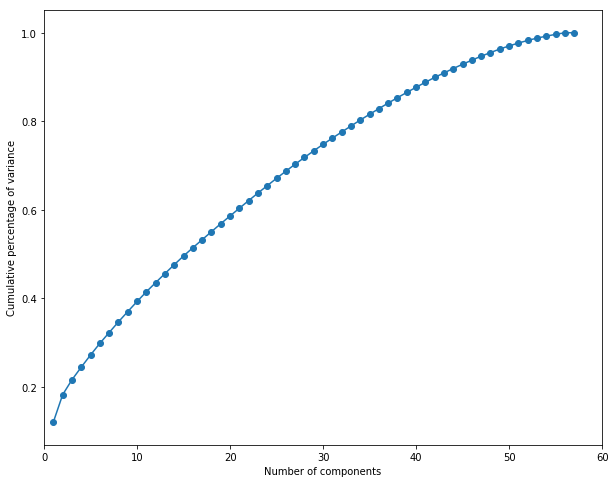

In [75]:
plt.scatter(range(1, 58), np.cumsum(pca.explained_variance_ratio_))
plt.plot(range(1, 58), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative percentage of variance')
plt.xlim(0, 60)
plt.show()

- The first 35 features contain 82.87% of the variance.
- It's significantly different from the previous case in which we did not scale the features.
- Fit a logistic model based on the first 35 components.

In [76]:
pca.set_params(n_components=35)
pca.fit(x_train_scale)
x_train_scale35 = pca.transform(x_train_scale)
logit.fit(x_train_scale35, y_train)
print("The training error is: %.4f" %(1 - logit.score(x_train_scale35, y_train)))

The training error is: 0.0809


Make predictions on the test set. **For the features in the test set, we should do exactly the same pre-processing as we did in the training set:**

- Divided by the standard deviation(the standard deviation of features in the training set).
- Transformed by the PCA model.

In [77]:
x_test_scale = pca.transform(x_test / np.std(x_train, 0))
print("The test error is: %.4f" %(1-logit.score(x_test_scale[:, :35], y_test)))

The test error is: 0.0926


<p><a name="case4"></a></p>
## Case 4: Image Compression

In this case, we will reduce the dimension of our data set using PCA.

The data used is [MNIST data](https://www.kaggle.com/c/digit-recognizer/data) from Kaggle, which has been used in previous classification example. The data include 42000 images of hand-drawn digits. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels.

In [78]:
!head ./data/train.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


In [79]:
import matplotlib.gridspec as gridspec
# function to visualize data
def visualize(data, n_sample=25):
    fig = plt.figure(figsize=(10, 10))
    num = int(n_sample**0.5)
    gs = gridspec.GridSpec(num, num)
    fig.subplots_adjust(wspace=0.01, hspace=0.02)
    l = len(data.iloc[1, :])
    ll = int(l**0.5)
    for i in range(num):
        for j in range(num):
            temp = np.array(data.loc[(num*i + j), :]).reshape(ll, ll)
            ax = plt.subplot(gs[i, j])
            ax.imshow(temp, cmap=plt.cm.gray, interpolation='nearest')
            ax.axis('off')
    plt.show()

In [80]:
import pandas as pd
df = pd.read_csv("./data/train.csv")
df_data = df.drop("label", 1)
df_label = df.label

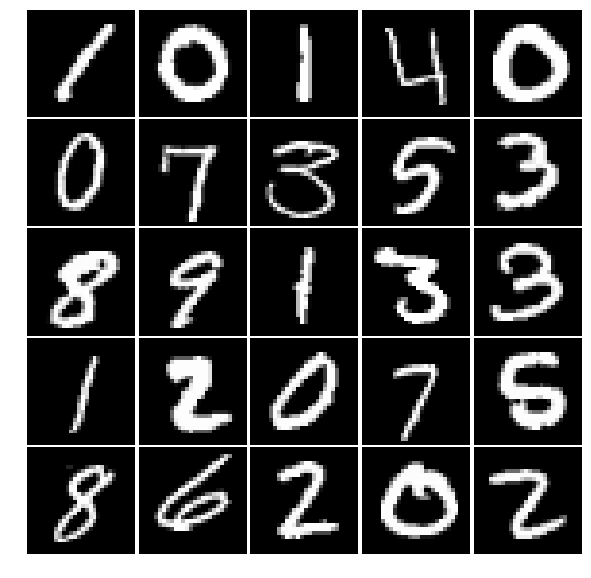

In [81]:
visualize(df_data)

### Keep 100 Dimensions (pixels)

In [89]:
from sklearn.decomposition import PCA
def visualizePCA(data, n_component=100):
    # remain first n components
    pca = PCA(n_components = n_component)
    df_data = pca.fit_transform(data) 
    # convert back to original data
    df_data = pca.inverse_transform(df_data)
    # convert to DataFrame and plot
    df_data = pd.DataFrame(df_data)
    visualize(df_data)

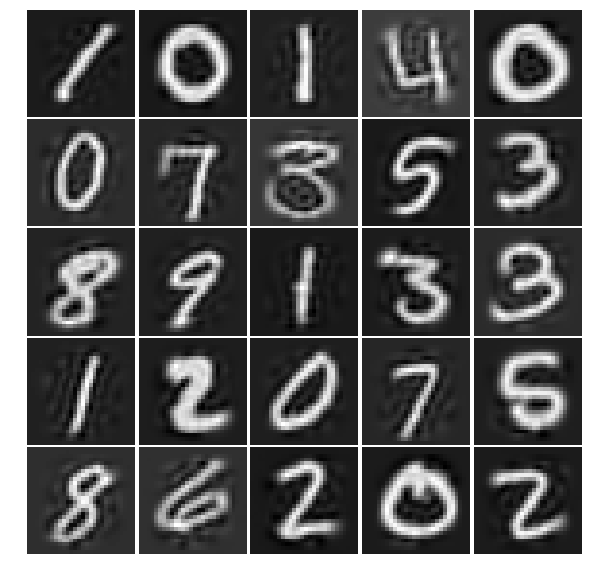

Wall time: 3.42 s


In [90]:
%time visualizePCA(df_data) # takes a small amount of time to run

- Keep the 100 highest variance dimensions (pixels)
- We can still vaguely see the digits.

### Keep 20 Dimensions (pixels)

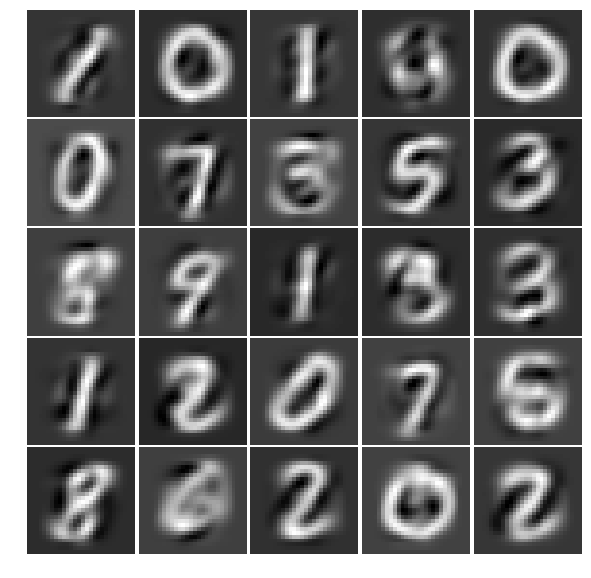

Wall time: 3.03 s


In [84]:
%time visualizePCA(df_data, 20)

- PCA keeps the 20 highest variance dimensions (pixels)
- Some digits are hard to recognize.
- However, we only have 20 dimensions data, which is faster to train.